In [1]:
!pip install editdistance
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q
!pip install editdistance

import locale
import pandas as pd
import numpy as np
import re
import sys
import typing as tp
import unicodedata
import gc
import random
import torch
import sacrebleu
import editdistance
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig, get_constant_schedule_with_warmup
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from sacremoses import MosesPunctNormalizer

pd.options.display.max_colwidth = 100

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 43.8 MB/s eta 0:00:00


In [3]:
trans_df = pd.read_csv('trans_df.csv')

trans_df.drop(columns = 'Unnamed: 0', inplace = True)
trans_df = trans_df[trans_df.ru.notna()]
print(trans_df.isnull().sum())

print(trans_df.split.value_counts())

df_train = trans_df[trans_df.split=='train'].copy()
df_dev = trans_df[trans_df.split=='dev'].copy()
df_test = trans_df[trans_df.split=='test'].copy()

ru       0
tyv      0
split    0
dtype: int64
split
train    108183
test       5000
dev        4999
Name: count, dtype: int64


In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [28]:
MODEL_URL = 'issai/tilmash'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
#tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
sum(p.numel() for p in model.parameters())

1370638336

In [30]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [31]:
def word_tokenize(text):
    return re.findall('(\w+|[^\w\s])', text)

texts_with_unk = [text for text in tqdm(trans_df.tyv) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/118182 [00:00<?, ?it/s]

3646


In [32]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [33]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/3646 [00:00<?, ?it/s]

18


In [34]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [35]:
fix_tokenizer(tokenizer)

In [36]:
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]

[256202, 256203, 256204]


In [37]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [38]:
model.resize_token_embeddings(len(tokenizer))

# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [39]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [40]:
model.cuda();

In [41]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [('ru', 'rus_Cyrl'), ('tyv', 'tyv_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['Ему с усунами-то управляться было не по силам!'], ['Бодунуң усун аймаан башкарары безин бергедеп турда!'], 'rus_Cyrl', 'tyv_Cyrl')


In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

  0%|          | 0/57000 [00:00<?, ?it/s]

0 2.849663019180298
1000 3.1616250544786455
2000 2.1345306417942047
3000 1.7900664443969727
4000 1.6086332690119742
5000 1.486025850534439
6000 1.3990401367545129
7000 1.330485082566738
8000 1.2583751863241195
9000 1.1996669675707816
10000 1.1646715589165688
11000 1.1364654975533486
12000 1.0873813209235668
13000 1.033030642360449
14000 1.0089454562664033
15000 0.9765372721552849
16000 0.9594591070711612
17000 0.9223249752223491
18000 0.8974194807410241
19000 0.8793236643075943
20000 0.8531999191939831
21000 0.8513278342783451
22000 0.8222060842812061
23000 0.7918415702581406
24000 0.7782305981963873
25000 0.7568473143577575
26000 0.7333586082309484
27000 0.7221075951159001
28000 0.6922372458875179
29000 0.6958485402464867
30000 0.6725418497025967
31000 0.6551760375052691
32000 0.6555214790403843
33000 0.6275034075081348
34000 0.6218092599213123
35000 0.592350131586194
36000 0.5828370650708675
37000 0.5777093684375286
38000 0.5591723776608706
39000 0.5503788063451648
40000 0.5354274151

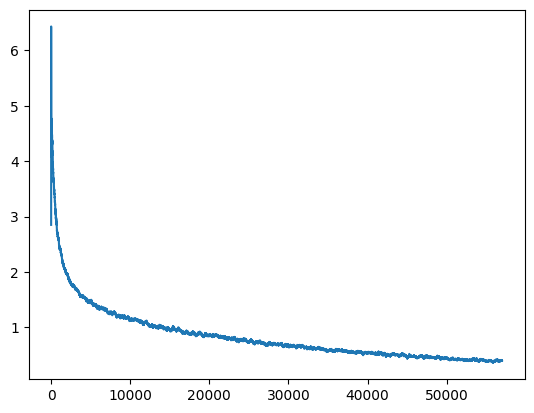

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [52]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [53]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 24.42 51.9/30.0/19.1/12.6 (BP = 0.987 ratio = 0.987 hyp_len = 22903 ref_len = 23207)
chrF2++ = 48.75
BLEU = 24.01 52.4/30.0/18.8/12.1 (BP = 0.982 ratio = 0.982 hyp_len = 22777 ref_len = 23188)
chrF2++ = 51.27


In [55]:
upload_repo = "Nacoor/tyvan_kz_1.3"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nacoor/tyvan_kz_1.3/commit/e7b8b4cd46a86a6b884cede579ba2fa38fffca19', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='e7b8b4cd46a86a6b884cede579ba2fa38fffca19', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
MODEL_URL = 'Nacoor/tyvan_kz_1.3'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/839 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [57]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [59]:
translate("когда мама приехала домой, мои друзья уже начали есть", model=model, tokenizer=tokenizer)

'авам чанып кээрге, эштерим чемненип эгелээннер'